# CNN Classification Task for Cats and Dogs**
### Created by Phebe Le - S2 Networking and Cybersecurity

### 1. Load data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Import required libraries

In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


The reason for the error in the pip install is because the notebook is not the latest version. This may cause errors but presumbly it will still maintain a model

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img




In [ ]:
tf.__version__

'2.12.0'

The use of inveption v3 is because of the beneficial architecture that is specifically used for image identification (therefore suitable for this task).

Inception v3 is a subtype of convolutional neural network model and it is more sophisticated then a typical model. It relies on transfer learning to increase the efficency and reduce the amount of training time

### 3. Link the dataset to Google Drive

In [ ]:
IMAGE_SIZE = [224,224] # image size used according to keras official documentation

## both image paths copied from good drive
train_path = '/content/drive/MyDrive/networking/data/train'
valid_path = '/content/drive/MyDrive/networking/data/validation'

In [ ]:
# Check to make sure all the output classes are there
# Go to goof

folders = glob('/content/drive/MyDrive/networking/data/train/*')
folders

['/content/drive/MyDrive/networking/data/train/cats',
 '/content/drive/MyDrive/networking/data/train/dogs']

### 4. Implementation of the inception v3 library

This is then added in front of a VGG (VGGNet: another type of cnn architecture) to increase the depth of neural networks

In [ ]:
inception = InceptionV3(input_shape = (150,150,3),
                        weights= 'imagenet',
                        include_top = False #Make the first and the last layer false because it is specific to 'ImageNet'
                      )

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Make layers non-trainable (don't train existing weights!)
# The lower layers can be retrained in the future to increase performance
# This could also lead to overfitting
for layer in inception.layers:
  layer.trainable = False

### 5. Creating the Training Model

In [ ]:
# These are all the layers within the model
# Flatten the inception layer to one dimension because the last layer is being removed
x = Flatten()(inception.output)

Here an error occured. Initially, what I wanted to write was ``layers.Flatten()``, because that was the convention I presumed the class would have but due to the inital error, it failed to work.Hence, I worked a way around it which was explicitly stating which functions were required from the library. Hence, the 'flatten' function now works.

In [ ]:
# Add a layer that's fully connected with 1024 hidden units and relu activation
x = Dense(1024, activation = 'relu')(x)

 The Relu activation function was chosen because 'softmax' is too large for this dataset. Others could work as well such as sigmoid.

In [ ]:
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)

This was created to hopefully prevent the model from overfitting in the future.


In [ ]:
# Create/add a final layer for classifiction using sigmoid
x = Dense(1, activation = 'sigmoid')(x)

In [ ]:
# create a model object with inputs as inception.input and output as this prediction 'x'

model = Model(inputs = inception.input, outputs = x)

In [ ]:
model.compile (
    optimizer = RMSprop(learning_rate = 0.0001),
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

- The optimiser could be changed to `ADAM` and other ones such as `Adagrad`. For now, the main test will be for RMSprop.

- `binary_crossentropy` is used as the loss metric as this task is a binary classification problem. Where there is two target classes

- This relayed an error because of legacy use of `lr` so `lr` will be changed to `learning_rate` instead.
- `acc` stands for accuracy in this case scenario, the measurement of accuracy

#### Model Summary

In [ ]:
# Summary of the model thus so far.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

From this model summary, the model has '1' layer inside the trainings. The model should also have  (0,150, 150, 3) within the input layer as a result of making the lower layers untrainable

### 6. Data Augumentation

In [ ]:
# Essentially importing the images from dataset to assist in the training later on

# adding data-argmentation parameters to ImageDataGenerato fo training datar
train_datagen = ImageDataGenerator(rescale = 1./255., # this number is required (according to several resources)
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)
# adding scaling parameters to the test data set
test_datagen = ImageDataGenerator(rescale = 1.0/255)


A rule that was found through serveral resources is that data argmentation techniques should be limited to the training data set (not be included for the test data set). This is because this would affect the testing phase and skew the results.

In [ ]:
# reading trained data from 'flow from directory' from the training path
training_data_set = train_datagen.flow_from_directory('/content/drive/MyDrive/networking/data/train',
                     target_size = (150,150),
                     batch_size = 16, # batch size is 16 because the RAM within Colab is low
                     class_mode = 'binary')


Found 1948 images belonging to 2 classes.


In [ ]:
# reading the testing data from 'flow from directory' from the testing path
testing_data_set = test_datagen.flow_from_directory('/content/drive/MyDrive/networking/data/validation',
                     target_size = (150,150),
                     batch_size = 16, # batch size is 16 because the RAM within Colab is low
                     class_mode = 'binary')

Found 728 images belonging to 2 classes.


### 7. Training/Fitting the Model

In [ ]:
training = model.fit(
    training_data_set,
    validation_data = testing_data_set,
    epochs = 5,
    steps_per_epoch = len(training_data_set),
    validation_steps = len(testing_data_set),
)

Epoch 1/5
122/122 [==============================] - 452s 4s/step - loss: 1.0690 - acc: 0.8516 - val_loss: 0.2251 - val_acc: 0.9327
Epoch 2/5
122/122 [==============================] - 120s 986ms/step - loss: 0.4398 - acc: 0.8866 - val_loss: 0.1827 - val_acc: 0.9519
Epoch 3/5
122/122 [==============================] - 119s 981ms/step - loss: 0.3410 - acc: 0.8994 - val_loss: 0.1328 - val_acc: 0.9574
Epoch 4/5
122/122 [==============================] - 121s 991ms/step - loss: 0.2744 - acc: 0.9107 - val_loss: 0.1353 - val_acc: 0.9547
Epoch 5/5
122/122 [==============================] - 120s 989ms/step - loss: 0.2638 - acc: 0.9153 - val_loss: 0.1183 - val_acc: 0.9698


The inital response of it is quite strong with an approximently 90% accuracy (as seen below)
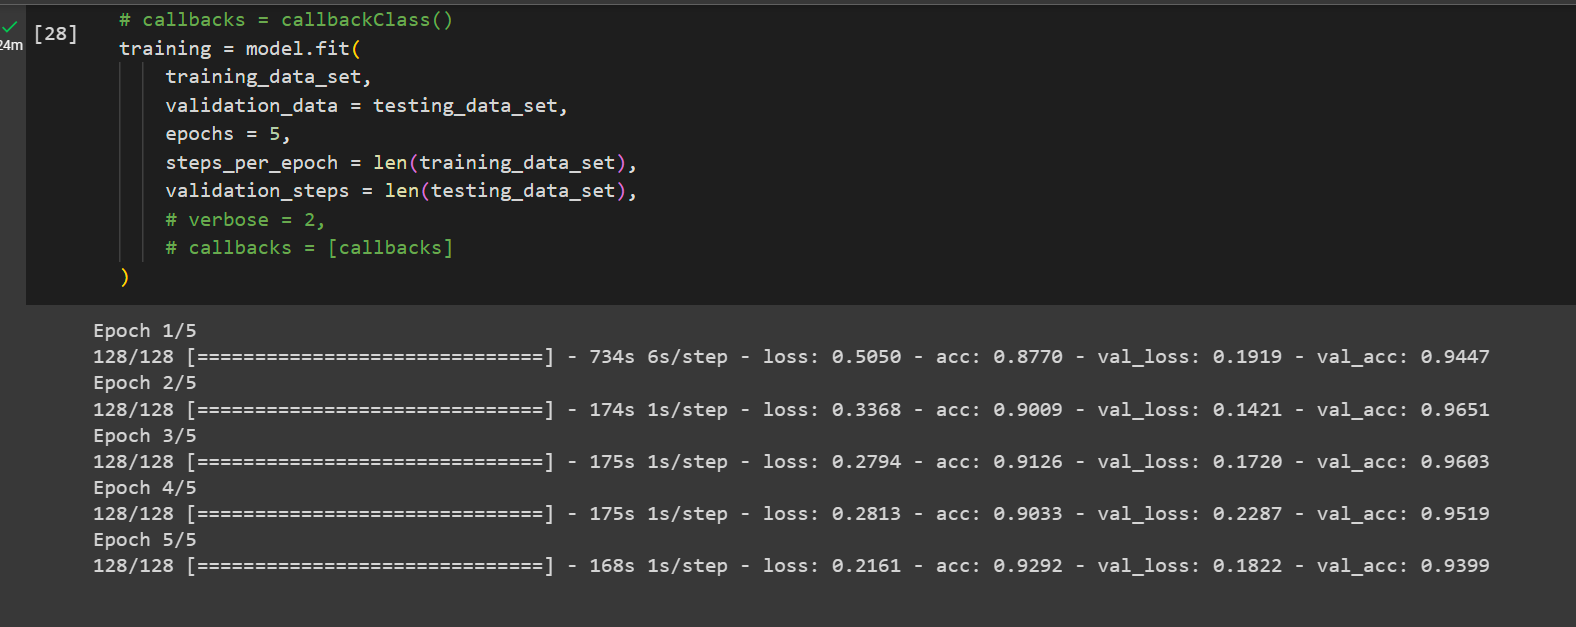

#### Visualising the model accuracy

To view the accuracy of the model, two line graphs are shown

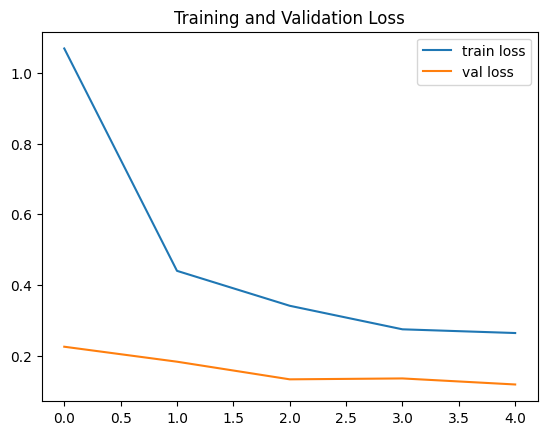

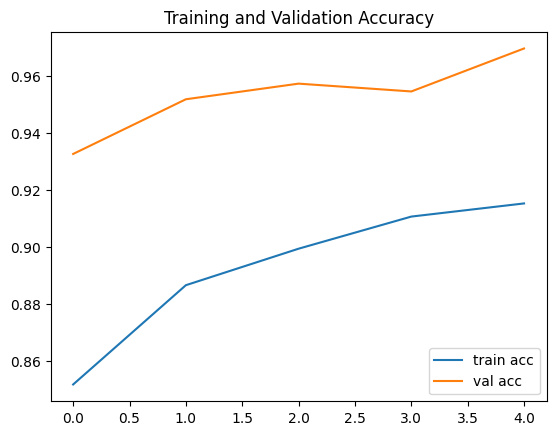

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the loss whilst training
plt.title('Training and Validation Loss')
plt.plot(training.history['loss'], label= 'train loss')
plt.plot(training.history['val_loss'], label = 'val loss')
plt.legend(loc = 'upper right')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy whilst training
plt.title('Training and Validation Accuracy')
plt.plot(training.history['acc'], label = 'train acc')
plt.plot(training.history['val_acc'], label = 'val acc')
plt.legend(loc = 'lower right')
plt.show()
plt.savefig('AccVal_acc')


If more epochs had been added the training and validation accuracy would be quite close to each other. 10 Epochs would work in this case scenario. Although, this would be quite consuming as it would take more than 1 hour to train (5 epochs = ~30 mins)

### 8. Evaluating data


#### Evaluation of the model
Here we evaulate the model using the testing data set. This will allow us to see how accurate the model is generally. Accoring to this test, there is an approximently 94% accuracy.

In [ ]:
model.evaluate(testing_data_set)


46/46 [==============================] - 22s 488ms/step - loss: 0.1183 - acc: 0.9698


[0.11825626343488693, 0.9697802066802979]

In [ ]:
model.save('phebe_model')

### 9. Predicting new data
- This section is to classify images that were not included in the training or validation sets
- In this case scenario it is an image of a dog and a cat

#### Infomation about/for the Prediction model

In [ ]:
# binary classification specifications for each data class
training_data_set.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
# used to help label the specifications
class_names = ['cat','dog']

#### The Prediction Model
- The 2 prediction images are centered within a folder named `predict`

In [ ]:
# predicting images
fn = 'cat.jpg'  # name of the image
path='/content/drive/MyDrive/networking/data/predict/' + fn     # path to the image
img=image.load_img(path, target_size=(150, 150))

#set up the prediction model
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

# Create and predict the model
classes = model.predict(images, batch_size= 5)
NumberElement = classes.argmax()

# print messages for viewer to understand
print(classes) #print the likelihood of it being in one of the classes
print ("Our Network has concluded that the likelyhood of this image being a cat is: ")
print (str(int(classes*100)) + "% Confidence Level")

1/1 [==============================] - 1s 1s/step
[[0.0010982]]
Our Network has concluded that the likelyhood of this image being a cat is: 
0% Confidence Level


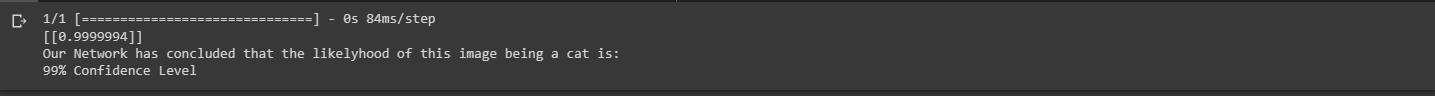

In [ ]:
fn = 'dog.jpg'  # name of the image
path='/content/drive/MyDrive/networking/data/predict/' + fn  # path to the image
imgs=image.load_img(path, target_size=(150, 150))

#set up the prediction model
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

# Create and predict the model
classes = model.predict(images, batch_size=50)
NumberElement = classes.argmax()

# print messages for viewer to understand
print(classes) #print the likelihood of it being in one of the classes
print("Our Network has concluded that the likelyhood of this image being a dog is: ")
print(str(int(classes*100)) + "% Confidence Level")

1/1 [==============================] - 0s 79ms/step
[[0.0010982]]
Our Network has concluded that the likelyhood of this image being a dog is: 
0% Confidence Level


### Modelling

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'task2_model_phebe.png', show_shapes=True)